<a href="https://colab.research.google.com/github/Hanifahmed/wind-energy-dhaka-2017/blob/main/notebooks/Wind_energy_dhaka_2017.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# Mount Google Drive (only once per Colab session)
from google.colab import drive
drive.mount('/content/drive')

import requests, pandas as pd

def download_wind_csv(api_key, email, lon, lat, out_path,
                      attributes="windspeed_100m,winddirection_100m,temperature_100m",
                      year="2017"):
    url = "https://developer.nrel.gov/api/wind-toolkit/v2/wind/wtk-bangladesh-download.csv"
    params = {
        "wkt": f"POINT({lon} {lat})",
        "attributes": attributes,
        "names": year,
        "utc": "true",
        "leap_day": "true",
        "interval": "60",
        "email": "hanifahmed29@gmail.com",
        "api_key": "dVKT5GNR2CmYMyt37uFKchV6w3MiRae1q7wBT5hC"
    }
    r = requests.get(url, params=params)
    with open(out_path, "wb") as f:
        f.write(r.content)
    print(f"✅ Saved CSV to: {out_path}")
    return out_path

# -----------------------------
# Example usage
# -----------------------------
API_KEY = "dVKT5GNR2CmYMyt37uFKchV6w3MiRae1q7wBT5hC"
EMAIL   = "hanifahmed29@gmail.com"
LON, LAT = 90.4125, 23.8103  # Dhaka
OUT_FILE = "/content/drive/MyDrive/nrel_dhaka_100m_2017.csv"

csv_path = download_wind_csv(API_KEY, EMAIL, LON, LAT, OUT_FILE)
df = pd.read_csv(csv_path, skiprows=1)   # skip metadata row
df.columns = [c.strip().replace(" ", "_").lower() for c in df.columns]  # clean column names
print(df.head())

Mounted at /content/drive
✅ Saved CSV to: /content/drive/MyDrive/nrel_dhaka_100m_2017.csv
   year  month  day  hour  minute  wind_speed_at_100m_(m/s)  \
0  2017      1    1     0       0                      0.88   
1  2017      1    1     1       0                      1.48   
2  2017      1    1     2       0                      2.59   
3  2017      1    1     3       0                      1.64   
4  2017      1    1     4       0                      1.33   

   wind_direction_at_100m_(deg)  air_temperature_at_100m_(c)  
0                         28.98                        18.52  
1                        335.10                        19.27  
2                        331.17                        20.76  
3                        345.77                        18.65  
4                         27.32                        18.96  


In [2]:

import pandas as pd

# Path to your saved file in Google Drive
file_path = "/content/drive/MyDrive/nrel_dhaka_100m_2017.csv"

# Load CSV
df = pd.read_csv(file_path, skiprows=1)  # skip first header row
df = df.rename(columns={
    "Year": "year",
    "Month": "month",
    "Day": "day",
    "Hour": "hour",
    "Minute": "minute",
    "wind speed at 100m (m/s)": "windspeed_100m",
    "wind direction at 100m (deg)": "winddir_100m",
    "air temperature at 100m (C)": "temp_100m"
})

# Keep only useful columns
df = df[["year", "month", "day", "hour", "windspeed_100m", "winddir_100m", "temp_100m"]]

# Compute Wind Power Density (W/m²)
rho = 1.225  # air density (kg/m³)
df["wpd"] = 0.5 * rho * (df["windspeed_100m"] ** 3)

# Show basic statistics
print("\n--- Basic Statistics ---")
print(df[["windspeed_100m", "winddir_100m", "temp_100m", "wpd"]].describe())

# Preview cleaned data
print("\n--- Data Preview ---")
print(df.head())


--- Basic Statistics ---
       windspeed_100m  winddir_100m    temp_100m           wpd
count     8712.000000   8712.000000  8712.000000  8.712000e+03
mean         3.912612    183.161736    25.503089  8.176149e+01
std          2.201284     89.953722     3.435407  3.291745e+02
min          0.010000      0.010000    12.170000  6.125000e-07
25%          2.320000    128.275000    23.287500  7.648390e+00
50%          3.650000    177.995000    26.030000  2.978411e+01
75%          5.130000    235.542500    27.840000  8.269099e+01
max         32.540000    359.800000    34.580000  2.110371e+04

--- Data Preview ---
   year  month  day  hour  windspeed_100m  winddir_100m  temp_100m        wpd
0  2017      1    1     0            0.88         28.98      18.52   0.417402
1  2017      1    1     1            1.48        335.10      19.27   1.985598
2  2017      1    1     2            2.59        331.17      20.76  10.641562
3  2017      1    1     3            1.64        345.77      18.65   2.70

In [3]:

# === Step 2: Monthly and Seasonal Analysis ===

# Group by month and calculate averages
monthly_stats = df.groupby("month")[["windspeed_100m", "winddir_100m", "temp_100m", "wpd"]].mean().reset_index()

print("\n--- Monthly Averages ---")
print(monthly_stats)

# Seasonal grouping (DJF=Winter, MAM=Spring, JJA=Summer, SON=Autumn)
season_map = {12: "Winter", 1: "Winter", 2: "Winter",
              3: "Spring", 4: "Spring", 5: "Spring",
              6: "Summer", 7: "Summer", 8: "Summer",
              9: "Autumn", 10: "Autumn", 11: "Autumn"}

df["season"] = df["month"].map(season_map)
seasonal_stats = df.groupby("season")[["windspeed_100m", "winddir_100m", "temp_100m", "wpd"]].mean().reset_index()

print("\n--- Seasonal Averages ---")
print(seasonal_stats.head())


--- Monthly Averages ---
    month  windspeed_100m  winddir_100m  temp_100m         wpd
0       1        3.482755    256.098360  20.645000   50.460028
1       2        3.146771    208.009256  23.776161   47.190183
2       3        3.773454    170.668965  24.332661   71.349925
3       4        5.183931    163.537889  26.437056  217.289954
4       5        4.219879    164.337809  28.092661  127.522618
5       6        4.188597    155.623917  27.702958   80.581792
6       7        4.099624    160.918468  27.249691   67.108991
7       8        4.271546    174.482594  27.706976   81.212901
8       9        4.306458    180.496417  27.667194   82.224617
9      10        3.711035    159.805538  26.443992   61.005713
10     11        3.491903    193.532542  24.313875   57.764843
11     12        2.990862    213.519454  21.367443   34.613608

--- Seasonal Averages ---
   season  windspeed_100m  winddir_100m  temp_100m         wpd
0  Autumn        3.835087    177.745499  26.145009   66.932537
1 


--- Daily Averages (first 5 rows) ---
                     windspeed_100m        wpd  windspeed_roll  wpd_roll
datetime                                                                
2017-01-01 00:00:00            0.88   0.417402             NaN       NaN
2017-01-01 01:00:00            1.48   1.985598             NaN       NaN
2017-01-01 02:00:00            2.59  10.641562             NaN       NaN
2017-01-01 03:00:00            1.64   2.701703             NaN       NaN
2017-01-01 04:00:00            1.33   1.440990             NaN       NaN


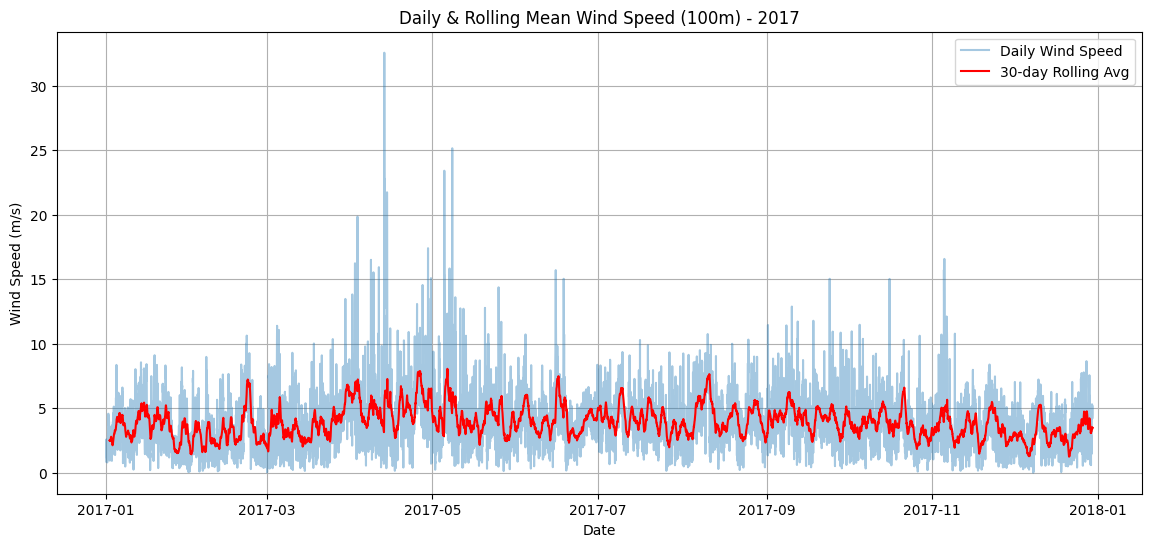

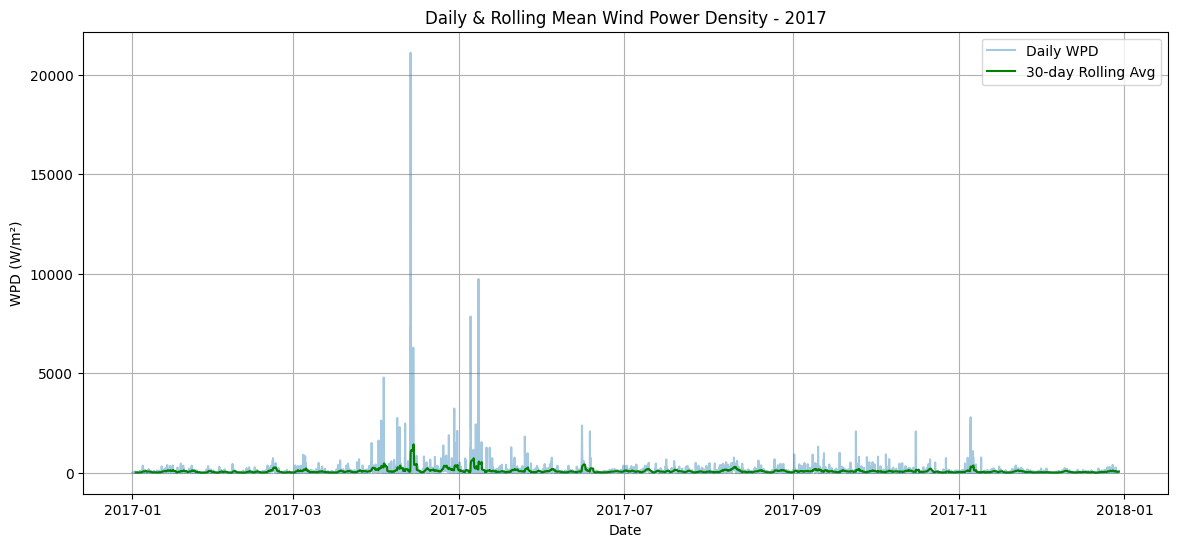

In [4]:

import matplotlib.pyplot as plt

# === Step 3: Time Series & Trend Analysis ===

# Create a datetime column
df["datetime"] = pd.to_datetime(df[["year", "month", "day", "hour"]])

# Daily averages
daily_stats = df.groupby("datetime")[["windspeed_100m", "wpd"]].mean()

# 30-day rolling mean
daily_stats["windspeed_roll"] = daily_stats["windspeed_100m"].rolling(window=30).mean()
daily_stats["wpd_roll"] = daily_stats["wpd"].rolling(window=30).mean()

print("\n--- Daily Averages (first 5 rows) ---")
print(daily_stats.head())

# --- Plot trends ---
plt.figure(figsize=(14,6))
plt.plot(daily_stats.index, daily_stats["windspeed_100m"], alpha=0.4, label="Daily Wind Speed")
plt.plot(daily_stats.index, daily_stats["windspeed_roll"], color="red", label="30-day Rolling Avg")
plt.title("Daily & Rolling Mean Wind Speed (100m) - 2017")
plt.xlabel("Date")
plt.ylabel("Wind Speed (m/s)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(14,6))
plt.plot(daily_stats.index, daily_stats["wpd"], alpha=0.4, label="Daily WPD")
plt.plot(daily_stats.index, daily_stats["wpd_roll"], color="green", label="30-day Rolling Avg")
plt.title("Daily & Rolling Mean Wind Power Density - 2017")
plt.xlabel("Date")
plt.ylabel("WPD (W/m²)")
plt.legend()
plt.grid(True)
plt.show()


--- Diurnal Cycle (Hourly Means) ---
      windspeed_100m  temp_100m         wpd
hour                                       
0           4.192342  23.160882   75.062772
1           3.686612  23.547851   52.365303
2           3.327879  23.928650   43.340859
3           2.852369  24.632782   30.474713
4           2.889477  25.607686   33.692520
5           3.111736  26.558402   51.136528
6           3.312452  27.171846   88.329875
7           3.451901  27.665041   73.736763
8           4.049256  27.825510  207.936381
9           4.007769  27.814793  116.678993
10          3.787466  27.740964  121.687519
11          3.810358  27.251405  100.474128


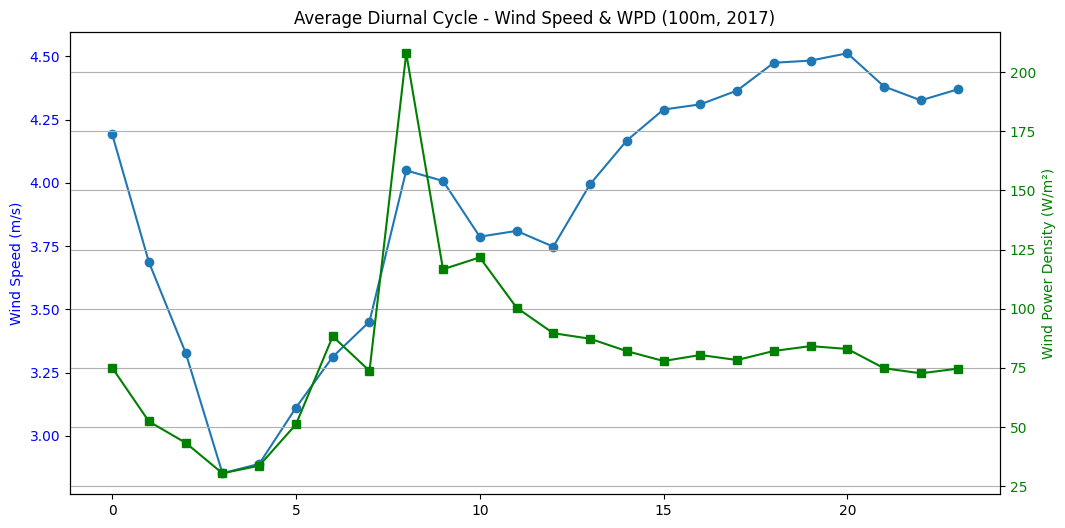

In [5]:

# === Step 4: Diurnal Cycle Analysis ===

# Group by hour of day
diurnal_stats = df.groupby("hour")[["windspeed_100m", "temp_100m", "wpd"]].mean()

print("\n--- Diurnal Cycle (Hourly Means) ---")
print(diurnal_stats.head(12))  # print first 12 hours

# --- Plot ---
fig, ax1 = plt.subplots(figsize=(12,6))

ax1.plot(diurnal_stats.index, diurnal_stats["windspeed_100m"], marker="o", label="Wind Speed (m/s)")
ax1.set_ylabel("Wind Speed (m/s)", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

ax2 = ax1.twinx()
ax2.plot(diurnal_stats.index, diurnal_stats["wpd"], marker="s", color="green", label="WPD (W/m²)")
ax2.set_ylabel("Wind Power Density (W/m²)", color="green")
ax2.tick_params(axis="y", labelcolor="green")

plt.title("Average Diurnal Cycle - Wind Speed & WPD (100m, 2017)")
plt.xlabel("Hour of Day")
plt.grid(True)
plt.show()

/tmp/ipython-input-3004843357.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  wind_rose = df.groupby("winddir_bin")["windspeed_100m"].mean()



--- Wind Rose Data (Sector Means) ---
winddir_bin
0      3.336941
30     3.374934
60     3.461596
90     3.883375
120    3.881261
150    4.461128
180    4.522379
210    3.720071
240    3.145625
270    3.068231
300    3.546605
330    3.765921
Name: windspeed_100m, dtype: float64


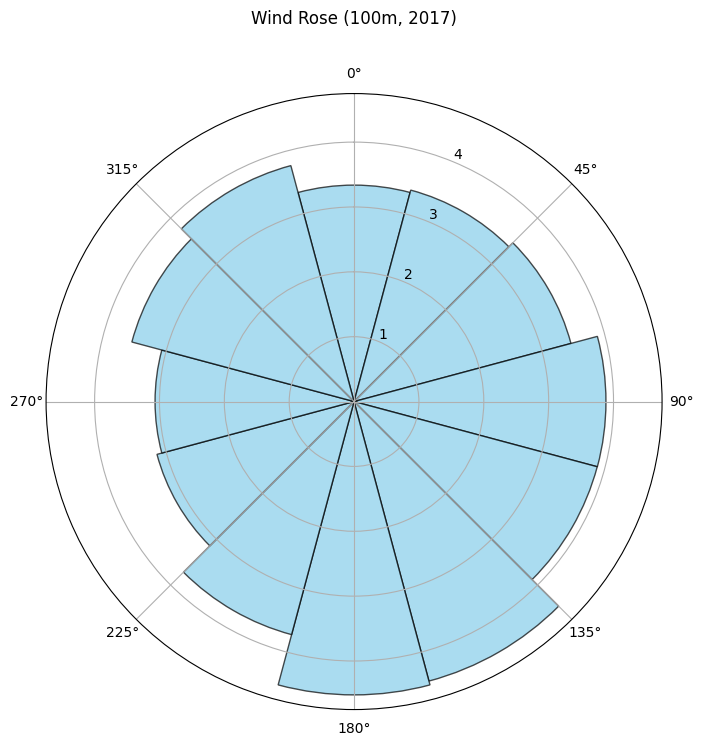

In [6]:
# === Step 5: Wind Rose (Directional Analysis) ===
import numpy as np

# Bin wind directions into 30° sectors
bins = np.arange(0, 361, 30)
df["winddir_bin"] = pd.cut(df["winddir_100m"], bins=bins, include_lowest=True, labels=bins[:-1])

# Mean wind speed by direction sector
wind_rose = df.groupby("winddir_bin")["windspeed_100m"].mean()

print("\n--- Wind Rose Data (Sector Means) ---")
print(wind_rose)

# --- Plot wind rose ---
theta = np.deg2rad(wind_rose.index.astype(float))
radii = wind_rose.values

plt.figure(figsize=(8,8))
ax = plt.subplot(111, polar=True)
bars = ax.bar(theta, radii, width=np.deg2rad(30), bottom=0, color="skyblue", edgecolor="black", alpha=0.7)

ax.set_theta_zero_location("N")   # North = 0°
ax.set_theta_direction(-1)        # Clockwise
ax.set_title("Wind Rose (100m, 2017)", y=1.1)
plt.show()


--- Turbine Energy Output ---
Single Turbine AEP: 1536.58 MWh
Single Turbine Capacity Factor: 8.77%

--- Wind Farm Energy Output ---
Number of Turbines: 50
Total Farm AEP: 76829.00 MWh
Installed Farm Capacity: 100.0 MW
Farm Capacity Factor: 8.77%

--- Power Output Preview ---
   windspeed_100m  power_kw
0            0.88         0
1            1.48         0
2            2.59         0
3            1.64         0
4            1.33         0
5            1.15         0
6            2.11         0
7            1.55         0
8            1.04         0
9            0.81         0


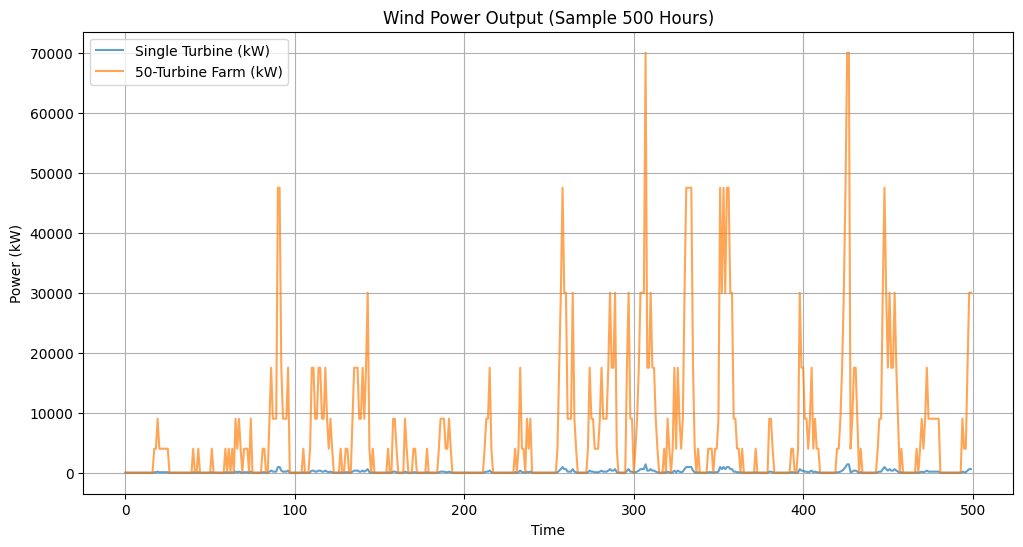

In [7]:

# === Step 6 (Final Version): Turbine + Wind Farm Energy Estimation ===

# Vestas V100 2.0 MW power curve (simplified)
power_curve = {
    0: 0, 1: 0, 2: 0, 3: 0,
    4: 80, 5: 180, 6: 350, 7: 600,
    8: 950, 9: 1400, 10: 1750, 11: 1950,
    12: 2000, 13: 2000, 14: 2000, 15: 2000,
    16: 2000, 17: 2000, 18: 2000, 19: 2000,
    20: 2000, 21: 2000, 22: 2000, 23: 2000,
    24: 2000, 25: 2000, 26: 0, 27: 0
}

# Function to map wind speed → power
def get_power(ws):
    if pd.isna(ws):   # handle NaN
        return 0
    ws_int = int(round(ws))
    return power_curve.get(ws_int, 0)

# Apply power curve to dataset
df["power_kw"] = df["windspeed_100m"].apply(get_power)

# --- Single Turbine Calculations ---
aep_mwh = df["power_kw"].sum() / 1000        # convert kWh → MWh
capacity_factor = aep_mwh / (2000 * 8760 / 1000)

# --- Wind Farm Scaling ---
N_TURBINES = 50   # change this number to scale
aep_farm_mwh = aep_mwh * N_TURBINES
farm_capacity_mw = (2000 * N_TURBINES) / 1000   # in MW

# --- Print Results ---
print("\n--- Turbine Energy Output ---")
print(f"Single Turbine AEP: {aep_mwh:.2f} MWh")
print(f"Single Turbine Capacity Factor: {capacity_factor:.2%}")

print("\n--- Wind Farm Energy Output ---")
print(f"Number of Turbines: {N_TURBINES}")
print(f"Total Farm AEP: {aep_farm_mwh:.2f} MWh")
print(f"Installed Farm Capacity: {farm_capacity_mw:.1f} MW")
print(f"Farm Capacity Factor: {capacity_factor:.2%}")  # same as turbine

print("\n--- Power Output Preview ---")
print(df[["windspeed_100m", "power_kw"]].head(10))

import matplotlib.pyplot as plt

# === Plotting Turbine & Farm Power Output (Sample: First 500 Hours) ===
plt.figure(figsize=(12, 6))
plt.plot(df.index[:500], df["power_kw"].iloc[:500], label="Single Turbine (kW)", alpha=0.7)
plt.plot(df.index[:500], df["power_kw"].iloc[:500] * N_TURBINES,
         label=f"{N_TURBINES}-Turbine Farm (kW)", alpha=0.7)

plt.title("Wind Power Output (Sample 500 Hours)")
plt.xlabel("Time")
plt.ylabel("Power (kW)")
plt.legend()
plt.grid(True)
plt.show()

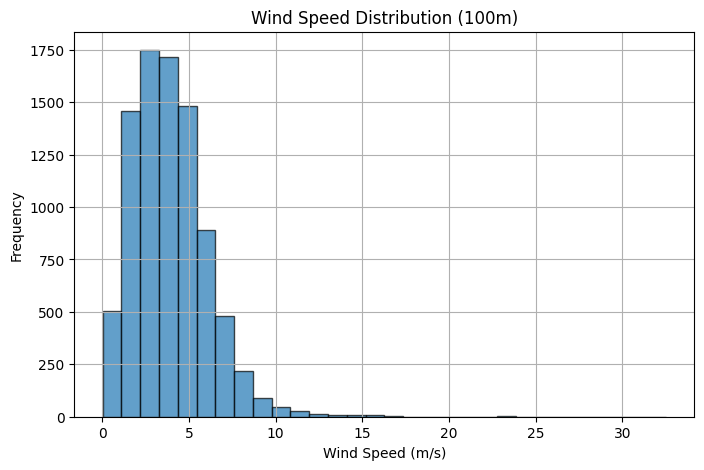

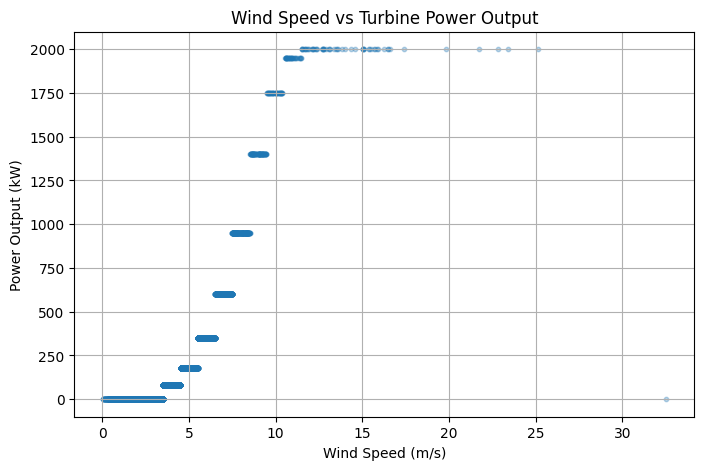

AttributeError: 'RangeIndex' object has no attribute 'month'

In [8]:

import matplotlib.pyplot as plt
import seaborn as sns

# === 1. Histogram of wind speeds ===
plt.figure(figsize=(8, 5))
plt.hist(df["windspeed_100m"], bins=30, edgecolor="k", alpha=0.7)
plt.title("Wind Speed Distribution (100m)")
plt.xlabel("Wind Speed (m/s)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# === 2. Wind Speed vs Power Scatter ===
plt.figure(figsize=(8, 5))
plt.scatter(df["windspeed_100m"], df["power_kw"], alpha=0.3, s=10)
plt.title("Wind Speed vs Turbine Power Output")
plt.xlabel("Wind Speed (m/s)")
plt.ylabel("Power Output (kW)")
plt.grid(True)
plt.show()

# === 3. Seasonal × Diurnal Heatmap ===
# Ensure datetime index exists
if "datetime" not in df.columns:
    df["datetime"] = pd.to_datetime(df[["year","month","day","hour"]])
    df.set_index("datetime", inplace=True)

df["month"] = df.index.month
df["hour"] = df.index.hour
pivot = df.pivot_table(index="hour", columns="month", values="windspeed_100m", aggfunc="mean")

plt.figure(figsize=(12, 6))
sns.heatmap(pivot, cmap="YlGnBu", annot=False, cbar_kws={'label': 'Wind Speed (m/s)'})
plt.title("Diurnal vs Seasonal Wind Speed (100m)")
plt.xlabel("Month")
plt.ylabel("Hour of Day")
plt.show()

In [11]:

# --- Imports ---
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# --- 0) Prepare data and lag features ---
required_cols = ["windspeed_100m", "winddir_100m", "temp_100m", "power_kw"]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise RuntimeError(f"Missing required columns: {missing}")

df_ml = df.copy().reset_index(drop=True)
lag_hours = [1, 3, 6, 12, 24]
for lag in lag_hours:
    df_ml[f"wspd_lag_{lag}"] = df_ml["windspeed_100m"].shift(lag)
    df_ml[f"temp_lag_{lag}"] = df_ml["temp_100m"].shift(lag)
    df_ml[f"dir_lag_{lag}"] = df_ml["winddir_100m"].shift(lag)
df_ml = df_ml.dropna().reset_index(drop=True)

# --- Features and target ---
feature_cols = [c for c in df_ml.columns if c.startswith(("windspeed","wspd_lag","temp_lag","dir_lag","winddir")) and c != "power_kw"]
for b in ["windspeed_100m", "winddir_100m", "temp_100m"]:
    if b not in feature_cols:
        feature_cols.insert(0, b)

X = df_ml[feature_cols].values
y = df_ml["power_kw"].values  # target

# --- 1) Train/Test split ---
n = len(df_ml)
train_n = int(n * 0.8)
X_train, X_test = X[:train_n], X[train_n:]
y_train, y_test = y[:train_n], y[train_n:]

# --- 2) Scale features ---
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

# --- 3) Random Forest baseline ---
rf = RandomForestRegressor(n_estimators=200, max_depth=12, random_state=42, n_jobs=-1)
rf.fit(X_train_s, y_train)
y_pred_rf = rf.predict(X_test_s)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print("\n=== Random Forest Results ===")
print(f"Test samples: {len(y_test)}")
print(f"MAE: {mae_rf:.3f} kW, RMSE: {rmse_rf:.3f} kW, R2: {r2_rf:.3f}")


=== Random Forest Results ===
Test samples: 1738
MAE: 0.001 kW, RMSE: 0.030 kW, R2: 1.000


In [13]:
# --- LSTM for Sequential Wind Forecasting (Fixed Version) ---

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1. Clean dataset (remove NaNs just in case)
df = df.dropna(subset=["windspeed_100m", "power_kw"]).reset_index(drop=True)

# 2. Define X and y
X = df[["windspeed_100m"]].values
y = df["power_kw"].values.reshape(-1, 1)

# 3. Scale features and target
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(np.nan_to_num(y))  # ensure no NaNs

# 4. Create sequences for LSTM (look-back = 24 timesteps)
def create_sequences(X, y, time_steps=24):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i+time_steps])
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 24
X_seq, y_seq = create_sequences(X_scaled, y_scaled, time_steps)

# 5. Train-test split (80/20)
split = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

# 6. Build LSTM model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss="mse",
              metrics=["mse"])

# 7. Train with validation split
history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_split=0.2,
                    verbose=1)

# 8. Predictions
y_pred_scaled = model.predict(X_test)
y_pred_scaled = np.clip(y_pred_scaled, 0, 1)  # keep inside scaler range

# Inverse transform
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_inv = scaler_y.inverse_transform(y_test)

# 9. Metrics
mae_lstm = mean_absolute_error(y_test_inv, y_pred)
rmse_lstm = np.sqrt(mean_squared_error(y_test_inv, y_pred))
r2_lstm = r2_score(y_test_inv, y_pred)

print("\n=== Fixed LSTM Results ===")
print(f"MAE: {mae_lstm:.3f} kW, RMSE: {rmse_lstm:.3f} kW, R²: {r2_lstm:.3f}")

Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


174/174 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - loss: 0.0289 - mse: 0.0289 - val_loss: 0.0223 - val_mse: 0.0223
Epoch 2/20
174/174 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.0257 - mse: 0.0257 - val_loss: 0.0229 - val_mse: 0.0229
Epoch 3/20
174/174 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.0223 - mse: 0.0223 - val_loss: 0.0228 - val_mse: 0.0228
Epoch 4/20
174/174 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 0.0253 - mse: 0.0253 - val_loss: 0.0224 - val_mse: 0.0224
Epoch 5/20
174/174 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.0229 - mse: 0.0229 - val_loss: 0.0223 - val_mse: 0.0223
Epoch 6/20
174/174 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0241 - mse: 0.0241 - val_loss: 0.0216 - val_mse: 0.0216
Epoch 7/20
174/174 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 0.0218 - mse: 0.0218 - val_loss: 0.0217 - val_mse: 0.0217
Epoch 8/20
174/174 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0223 - mse: 0.0223 - val_loss: 0.0222 - val_mse: 0.0222
Epoch 9/20
174/174 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss

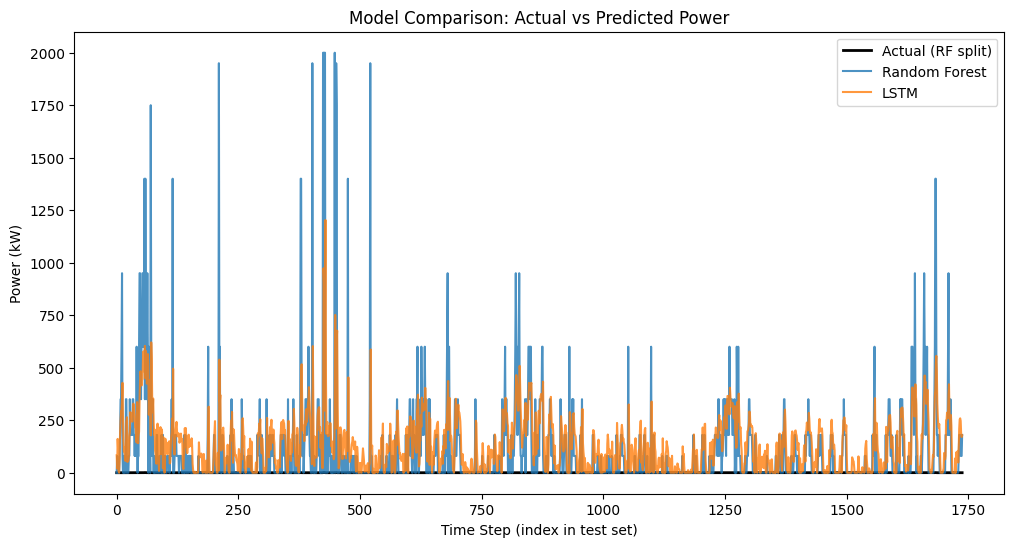

In [16]:

import matplotlib.pyplot as plt

# --- Use the correct RF test split ---
y_pred_rf = rf.predict(X_test_s)   # 2D features

# --- LSTM results (already inverse-scaled) ---
# y_test_inv, y_pred come from LSTM section

# --- Align lengths ---
min_len = min(len(y_test), len(y_test_inv), len(y_pred), len(y_pred_rf))

y_test_vis = y_test[:min_len]             # RF actuals
y_pred_rf_vis = y_pred_rf[:min_len]       # RF preds
y_test_lstm_vis = y_test_inv[:min_len]    # LSTM actuals
y_pred_lstm_vis = y_pred[:min_len]        # LSTM preds

# --- Plot comparison ---
plt.figure(figsize=(12,6))
plt.plot(y_test_vis, label="Actual (RF split)", color="black", linewidth=2)
plt.plot(y_pred_rf_vis, label="Random Forest", alpha=0.8)
plt.plot(y_pred_lstm_vis, label="LSTM", alpha=0.8)
plt.title("Model Comparison: Actual vs Predicted Power")
plt.xlabel("Time Step (index in test set)")
plt.ylabel("Power (kW)")
plt.legend()
plt.show()

In [17]:
# -------------------------
# Finalize & export Dhaka results to Google Drive
# -------------------------
import os, json, joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

OUT_DIR = "/content/drive/MyDrive/WindProject/Dhaka_2017"
os.makedirs(OUT_DIR, exist_ok=True)
print("Output folder:", OUT_DIR)

saved = []

# 1) Save cleaned dataframe (df)
try:
    df.to_csv(os.path.join(OUT_DIR, "cleaned_df.csv"), index=False)
    saved.append("cleaned_df.csv")
except Exception as e:
    print("Could not save cleaned_df:", e)

# 2) Save df_ml if it exists (contains lag features used for RF)
try:
    if 'df_ml' in globals():
        df_ml.to_csv(os.path.join(OUT_DIR, "df_ml_with_lags.csv"), index=False)
        saved.append("df_ml_with_lags.csv")
except Exception as e:
    print("Could not save df_ml:", e)

# 3) Save test predictions (align RF & LSTM test arrays where possible)
try:
    # RF test arrays: y_test (1D numpy) and y_pred_rf (1D numpy)
    # LSTM test arrays: y_test_inv, y_pred (both shape (n,1))
    rf_present = ('y_test' in globals() and 'y_pred_rf' in globals())
    lstm_present = ('y_test_inv' in globals() and 'y_pred' in globals())

    # Build a predictions table from available arrays
    rows = {}
    if rf_present:
        rows['actual_rf'] = np.asarray(y_test).flatten()
        rows['pred_rf']   = np.asarray(y_pred_rf).flatten()
    if lstm_present:
        rows['actual_lstm'] = np.asarray(y_test_inv).flatten()
        rows['pred_lstm']   = np.asarray(y_pred).flatten()

    if rows:
        # Truncate to minimum length to align
        min_len = min(len(v) for v in rows.values())
        pred_df = pd.DataFrame({k: v[:min_len] for k, v in rows.items()})
        pred_path = os.path.join(OUT_DIR, "predictions_test_aligned.csv")
        pred_df.to_csv(pred_path, index=False)
        saved.append("predictions_test_aligned.csv")
except Exception as e:
    print("Could not save predictions CSV:", e)

# 4) Save key metrics (RF, LSTM, energy)
metrics = {}
metrics['single_turbine_aep_mwh'] = float(aep_mwh) if 'aep_mwh' in globals() else None
metrics['single_turbine_cf'] = float(capacity_factor) if 'capacity_factor' in globals() else None
metrics['n_turbines'] = int(N_TURBINES) if 'N_TURBINES' in globals() else None

if 'mae_rf' in globals(): metrics['rf_mae_kW'] = float(mae_rf)
if 'rmse_rf' in globals(): metrics['rf_rmse_kW'] = float(rmse_rf)
if 'r2_rf' in globals(): metrics['rf_r2'] = float(r2_rf)

if 'mae_lstm' in globals(): metrics['lstm_mae_kW'] = float(mae_lstm)
if 'rmse_lstm' in globals(): metrics['lstm_rmse_kW'] = float(rmse_lstm)
if 'r2_lstm' in globals(): metrics['lstm_r2'] = float(r2_lstm)

metrics_path = os.path.join(OUT_DIR, "metrics_summary.json")
with open(metrics_path, "w") as f:
    json.dump(metrics, f, indent=2)
saved.append("metrics_summary.json")

# 5) Save a short human-readable summary (Markdown)
summary_lines = [
    "# Dhaka Wind Assessment — Summary",
    "",
    f"Single turbine AEP (MWh): {metrics.get('single_turbine_aep_mwh')}",
    f"Single turbine Capacity Factor: {metrics.get('single_turbine_cf')}",
    f"Number of turbines used for farm scaling (if set): {metrics.get('n_turbines')}",
    "",
    "## Model performance",
    f"- Random Forest: MAE={metrics.get('rf_mae_kW')}, RMSE={metrics.get('rf_rmse_kW')}, R2={metrics.get('rf_r2')}",
    f"- LSTM:         MAE={metrics.get('lstm_mae_kW')}, RMSE={metrics.get('lstm_rmse_kW')}, R2={metrics.get('lstm_r2')}",
    "",
    "## Notes",
    "- RF gave very strong fit on test split; TimeSeriesSplit reduced over-optimism.",
    "- LSTM behaved less accurately on this dataset — consider more features or longer records.",
    "- This site (Dhaka) showed low resource (CF ~ {0:.2%}). Consider coastal sites for utility-scale projects.".format(metrics.get('single_turbine_cf') if metrics.get('single_turbine_cf') else 0),
]
summary_text = "\n".join(summary_lines)
with open(os.path.join(OUT_DIR, "summary.md"), "w") as f:
    f.write(summary_text)
saved.append("summary.md")

# 6) Save models (if present)
try:
    if 'rf' in globals():
        joblib.dump(rf, os.path.join(OUT_DIR, "rf_model.joblib"))
        saved.append("rf_model.joblib")
except Exception as e:
    print("Could not save RandomForest model:", e)

try:
    if 'model' in globals():
        model.save(os.path.join(OUT_DIR, "lstm_model.keras"))
        saved.append("lstm_model.keras")
except Exception as e:
    print("Could not save LSTM model:", e)

# 7) Regenerate & save important plots (histogram, scatter, model comparison)
try:
    # Histogram
    plt.figure(figsize=(7,4))
    plt.hist(df["windspeed_100m"].dropna(), bins=30, edgecolor="k", alpha=0.7)
    plt.title("Wind Speed Distribution (100m)")
    plt.xlabel("Wind Speed (m/s)")
    plt.ylabel("Frequency")
    p = os.path.join(OUT_DIR, "hist_windspeed.png")
    plt.savefig(p, bbox_inches="tight")
    plt.close()
    saved.append("hist_windspeed.png")
except Exception as e:
    print("Could not save histogram:", e)

try:
    # scatter windspeed vs power
    plt.figure(figsize=(7,4))
    plt.scatter(df["windspeed_100m"], df.get("power_kw", pd.Series([])), s=8, alpha=0.5)
    plt.xlabel("Wind Speed (m/s)")
    plt.ylabel("Power (kW)")
    plt.title("Wind Speed vs Power (sample)")
    p = os.path.join(OUT_DIR, "windspeed_vs_power.png")
    plt.savefig(p, bbox_inches="tight")
    plt.close()
    saved.append("windspeed_vs_power.png")
except Exception as e:
    print("Could not save scatter:", e)

try:
    # model comparison plot (if predictions available)
    if rf_present and lstm_present:
        min_len = min(len(y_test), len(y_pred_rf), len(y_test_inv), len(y_pred))
        plt.figure(figsize=(10,5))
        plt.plot(y_test[:min_len], label="Actual (RF split)", color="k", linewidth=1)
        plt.plot(y_pred_rf[:min_len], label="Random Forest", alpha=0.8)
        plt.plot(y_pred[:min_len], label="LSTM", alpha=0.8)
        plt.legend()
        plt.title("Actual vs RF vs LSTM (aligned slice)")
        p = os.path.join(OUT_DIR, "model_comparison.png")
        plt.savefig(p, bbox_inches="tight")
        plt.close()
        saved.append("model_comparison.png")
except Exception as e:
    print("Could not save model comparison plot:", e)

# 8) List saved files
print("\nSaved files:")
for name in saved:
    print("-", name)

print("\nDone. All saved under:", OUT_DIR)

Output folder: /content/drive/MyDrive/WindProject/Dhaka_2017

Saved files:
- cleaned_df.csv
- df_ml_with_lags.csv
- predictions_test_aligned.csv
- metrics_summary.json
- summary.md
- rf_model.joblib
- lstm_model.keras
- hist_windspeed.png
- windspeed_vs_power.png
- model_comparison.png

Done. All saved under: /content/drive/MyDrive/WindProject/Dhaka_2017
